In [22]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
sns.set(style="white")
sns.set(font='SimHei')

In [13]:
df = pd.read_csv('momo_sm_202012280955.csv')

In [7]:
df.drop(df[df['type'] == 0].index, inplace=True)
df.head()

,user_id,voc_id,first_response,repeat_long,used_interval,first_grade,pp,p
0,2566,180,4,3,4,4.0,0.868940,1
1,37454,488,4,3,3,4.0,0.900000,1
2,37454,488,4,4,5,4.0,0.927505,1
3,37454,488,4,5,7,4.0,0.948683,1
4,37454,488,4,6,15,4.0,0.920186,1


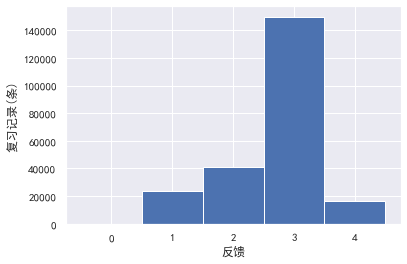

In [29]:
plt.hist(df['ease'], bins=np.arange(6)-0.5)
plt.ylabel('复习记录(条)')
plt.xlabel('反馈')
plt.show()

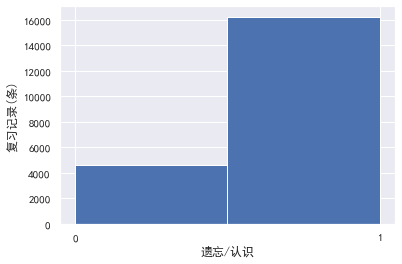

In [66]:
plt.hist(df['p'], bins=2)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.ylabel('复习记录(条)')
plt.xlabel('遗忘/认识')
plt.show()

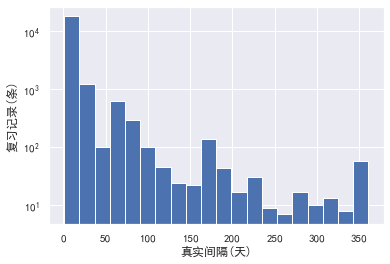

In [67]:
plt.hist([x for x in df['used_interval']], bins=20)
plt.xlabel('真实间隔(天)')
plt.ylabel('复习记录(条)')
plt.yscale('log')
plt.show()

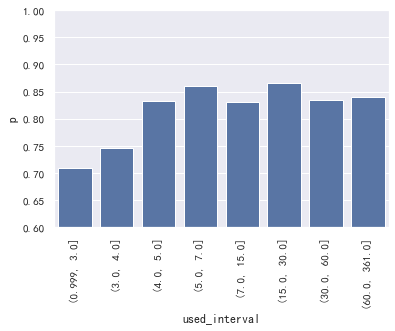

In [68]:
def _compute_bin_p_recall(group):
    return pd.DataFrame([
        {'p': group['p'].mean()}
    ])
global_forgetting = df.groupby(
    pd.qcut(df['used_interval'], 20, duplicates="drop")
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)
sns.barplot(x='used_interval', y='p', data=global_forgetting, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.6, 1)
plt.show()

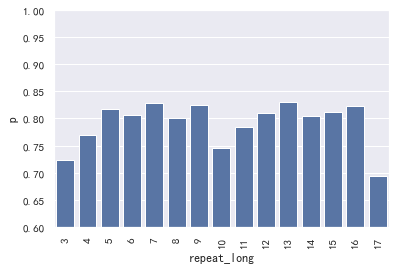

In [69]:
global_repeat_long = df.groupby(
    df['repeat_long']
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)[:15]
sns.barplot(x='repeat_long', y='p', data=global_repeat_long, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.6, 1)
plt.show()

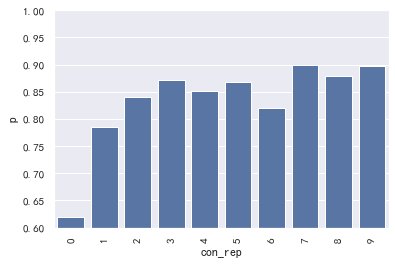

In [70]:
global_repeat_long = df.groupby(
    df['con_rep']
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)[:10]
sns.barplot(x='con_rep', y='p', data=global_repeat_long, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.6, 1)
plt.show()

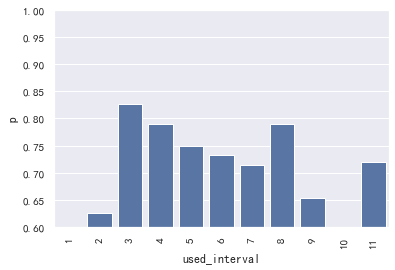

In [71]:
traces = df[df.repeat_long == 3]
global_lu = traces.groupby(
    df['used_interval']
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)[:15]
sns.barplot(x='used_interval', y='p', data=global_lu, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.6, 1)
plt.show()

In [54]:
traces = traces[traces.ease == 3]
plt.hist([x for x in traces['used_interval'] if x <= 10], bins=np.arange(10+1)-0.5)
plt.xlabel('真实间隔(天)')
plt.ylabel('复习记录(条)')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'ease'

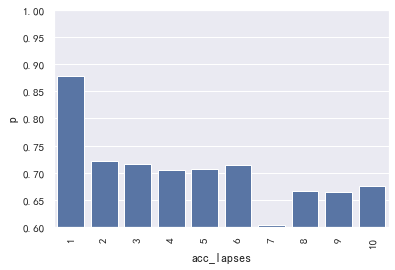

In [55]:
global_repeat_long = df.groupby(
    df['acc_lapses']
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)[:10]
sns.barplot(x='acc_lapses', y='p', data=global_repeat_long, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.6, 1)
plt.show()

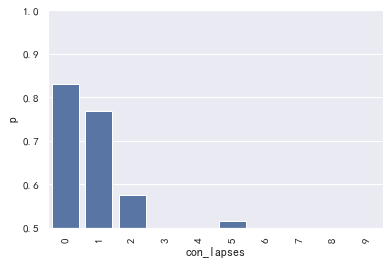

In [56]:
global_repeat_long = df.groupby(
    df['con_lapses']
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)[:10]
sns.barplot(x='con_lapses', y='p', data=global_repeat_long, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.show()

In [30]:
plt.hist([x for x in df.drop_duplicates(['cid'], keep='last')['acc_lapses'] if x <= 10], bins=10)
plt.xlim(0, 9)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('累计遗忘(次)')
plt.ylabel('复习记录(条)')
# plt.yscale('log')
plt.show()

KeyError: Index(['cid'], dtype='object')

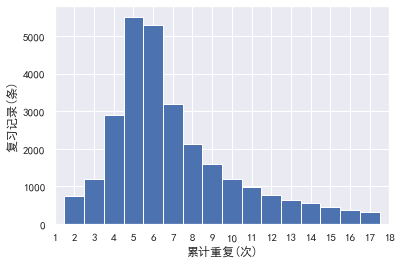

In [14]:
plt.hist([
    x for x in df.drop_duplicates(['cid'], keep='last')['repeat_long']
    if x <= 18
], bins=np.arange(18+1)-0.5)
plt.xlim(1, 18)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('累计重复(次)')
plt.ylabel('复习记录(条)')
# plt.yscale('log')
plt.show()

In [288]:
df['pp'] = 0.8029878575651462

In [6]:
def load_brier(predictions, real, bins=20):
    counts = np.zeros(bins)
    correct = np.zeros(bins)
    prediction = np.zeros(bins)
    for p, r in zip(predictions, real):
        bin = min(int(p * bins), bins - 1)
        counts[bin] += 1
        correct[bin] += r
        prediction[bin] += p
    prediction_means = prediction / counts
    prediction_means[np.isnan(prediction_means)] = ((np.arange(bins) + 0.5) / bins)[np.isnan(prediction_means)]
    correct_means = correct / counts
    # correct_means[np.isnan(correct_means)] = 0
    size = len(predictions)
    answer_mean = sum(correct) / size
    return {
        "reliability": sum(counts * (correct_means - prediction_means) ** 2) / size,
        "resolution": sum(counts * (correct_means - answer_mean) ** 2) / size,
        "uncertainty": answer_mean * (1 - answer_mean),
        "detail": {
            "bin_count": bins,
            "bin_counts": list(counts),
            "bin_prediction_means": list(prediction_means),
            "bin_correct_means": list(correct_means),
        }
    }


def plot_brier(predictions, real, bins=20):
    brier = load_brier(predictions, real, bins=bins)
    plt.figure()
    plt.plot((0, 1), (0, 1), label='Optimal average observation')
    plt.plot(brier['detail']['bin_prediction_means'], brier['detail']['bin_correct_means'],  '*', label='Average observation',)
    bin_count = brier['detail']['bin_count']
    counts = np.array(brier['detail']['bin_counts'])
    bins = (np.arange(bin_count) + 0.5) / bin_count
    plt.legend(loc='upper center')
    plt.xlabel('Prediction')
    plt.ylabel('Observeation')
    plt.twinx()
    plt.ylabel('Number of predictions')
    plt.bar(bins, counts, width=(0.5 / bin_count), alpha=0.5, label='Number of predictions')
    plt.legend(loc='lower center')

AUC: 0.6566361214554547


<Figure size 432x288 with 0 Axes>

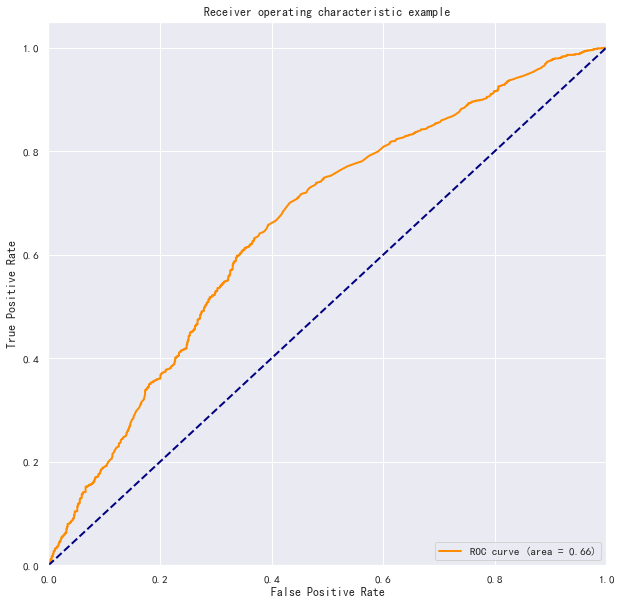

In [29]:

fpr, tpr, threshold = roc_curve(df['p'], df['pp'])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)
plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  # 假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

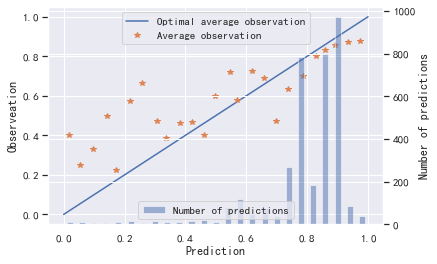

In [26]:
plot_brier(df['pp'], df['p'], 25)
plt.show()

In [311]:
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8030515016779042
MAE: 0.29595436307869194
RMSE: 0.3847271156262529
LL: 0.4672353738596809
r2_score: 0.06414294052795344


In [289]:
df = pd.read_csv('momo_sm_202012280955.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8029878575651462
MAE: 0.28679109272830905
RMSE: 0.3975038796966017
LL: 0.5004298481906383
r2_score: 0.0011948530719348982


In [166]:
df = pd.read_csv('momo_sm_202012281834.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8029878575651462
MAE: 0.2662037520339905
RMSE: 0.3980020351051101
LL: 0.5048741130633347
r2_score: -0.0013101386267642123


In [167]:
df = pd.read_csv('momo_sm_202012290427.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8029878575651462
MAE: 0.27736597910940985
RMSE: 0.3973913708432532
LL: 0.5005818324854053
r2_score: 0.0017601734343335451


In [168]:
df = pd.read_csv('momo_sm_202012291431.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.3089827693196836
RMSE: 0.42406086955285704
LL: 0.5613585900973909
r2_score: 0.011750084077133849


In [169]:
df = pd.read_csv('momo_sm_202012291451.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.31346886850640676
RMSE: 0.41789941374651424
LL: 0.5384847782112461
r2_score: 0.04025930374802267


In [164]:
df = pd.read_csv('momo_sm_202012291508.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.3130220832121951
RMSE: 0.417728653510952
LL: 0.5381085248053739
r2_score: 0.041043473617049075


In [140]:
df = pd.read_csv('momo_sm_202012291522.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.314371240342692
RMSE: 0.4178845898446703
LL: 0.5382825319339953
r2_score: 0.04032739118281692


In [139]:
df = pd.read_csv('momo_sm_202012291539.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.3138161271079119
RMSE: 0.41768429400449947
LL: 0.5378803953081753
r2_score: 0.04124713012572667


In [163]:
df = pd.read_csv('momo_sm_202012291647.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.31741134225212114
RMSE: 0.4234376358187053
LL: 0.559111189632609
r2_score: 0.01465277156277267


In [162]:
df = pd.read_csv('momo_sm_202012291951.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8029878575651462
MAE: 0.28432030684354154
RMSE: 0.39853229399433554
LL: 0.503709566830665
r2_score: -0.003980010890099583


In [161]:
df = pd.read_csv('momo_sm_202012300104.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.31163383190846106
RMSE: 0.4274304051298627
LL: 0.5604885124061764
r2_score: -0.004017335888809814


In [160]:
df = pd.read_csv('momo_sm_202012302029.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8029878575651462
MAE: 0.28113648790726725
RMSE: 0.3972574026186347
LL: 0.5003170717411138
r2_score: 0.0024331114256548325


In [174]:
df = pd.read_csv('momo_sm_202012311811.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.3146885818598915
RMSE: 0.4176549702578504
LL: 0.5378728068806113
r2_score: 0.04138174490426494


In [219]:
df = pd.read_csv('momo_sm_202012311956.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8029878575651462
MAE: 0.27639333011406786
RMSE: 0.39693481112844337
LL: 0.4999057657490868
r2_score: 0.0040525950454458615


In [170]:
df = pd.read_csv('momo_sm_202012312253.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.31092235609000424
RMSE: 0.42613367270590186
LL: 0.557710793218263
r2_score: 0.0020653709637764583


In [266]:
df = pd.read_csv('momo_sm_202101011344.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.30864831901534584
RMSE: 0.4170525910677065
LL: 0.5369913837412281
r2_score: 0.04414496001305335


In [313]:
df = pd.read_csv('lr_full.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8030515016779042
MAE: 0.29595436307869194
RMSE: 0.3847271156262529
LL: 0.4672353738596809
r2_score: 0.06414294052795344


In [3]:
df = pd.read_csv('momo_sm_202101011439.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8029878575651462
MAE: 0.27147911375122596
RMSE: 0.3960090193328171
LL: 0.49680259118352776
r2_score: 0.008692977544570657


In [31]:
df = pd.read_csv('momo_sm_202101020212.csv')
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.7608337904552934
MAE: 0.3110128011010583
RMSE: 0.4175391338747475
LL: 0.5377447487000322
r2_score: 0.04191341568762763


In [322]:
df.to_csv('revlog_202012160921_predict.csv', index=False)